# Машинное обучение, ФКН ВШЭ

## Практическое задание 8. Метод опорных векторов и аппроксимация ядер

### Общая информация

Дата выдачи: 30.01.2025

Мягкий дедлайн: 23:59MSK 16.02.2025

Жесткий дедлайн: 23:59MSK 23.02.2025

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимальная оценка за работу (без учёта бонусов) — 10 баллов.

Сдавать задание после указанного жёсткого срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник). 

Использование генеративных языковых моделей разрешено только в случае явного указания на это. Необходимо прописать (в соответствующих пунктах, где использовались, либо в начале/конце работы):
- какая языковая модель использовалась
- какие использовались промпты и в каких частях работы
- с какими сложностями вы столкнулись при использовании генеративных моделей, с чем они помогли больше всего

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-08-random-features-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

На занятиях мы подробно обсуждали метод опорных векторов (SVM). В базовой версии в нём нет чего-то особенного — мы всего лишь используем специальную функцию потерь, которая не требует устремлять отступы к бесконечности; ей достаточно, чтобы отступы были не меньше +1. Затем мы узнали, что SVM можно переписать в двойственном виде, который, позволяет заменить скалярные произведения объектов на ядра. Это будет соответствовать построению модели в новом пространстве более высокой размерности, координаты которого представляют собой нелинейные модификации исходных признаков.

Ядровой SVM, к сожалению, довольно затратен по памяти (нужно хранить матрицу Грама размера $d \times d$) и по времени (нужно решать задачу условной оптимизации с квадратичной функцией, а это не очень быстро). Мы обсуждали, что есть способы посчитать новые признаки $\tilde \varphi(x)$ на основе исходных так, что скалярные произведения этих новых $\langle \tilde \varphi(x), \tilde \varphi(z) \rangle$ приближают ядро $K(x, z)$.

Мы будем исследовать аппроксимации методом Random Fourier Features (RFF, также в литературе встречается название Random Kitchen Sinks) для гауссовых ядер. Будем использовать формулы, которые немного отличаются от того, что было на лекциях (мы добавим сдвиги внутрь тригонометрических функций и будем использовать только косинусы, потому что с нужным сдвигом косинус превратится в синус):
$$\tilde \varphi(x) = (
\cos (w_1^T x + b_1),
\dots,
\cos (w_n^T x + b_n)
),$$
где $w_j \sim \mathcal{N}(0, 1/\sigma^2)$, $b_j \sim U[-\pi, \pi]$.

На новых признаках $\tilde \varphi(x)$ мы будем строить любую линейную модель.

Можно считать, что это некоторая новая парадигма построения сложных моделей. Можно направленно искать сложные нелинейные закономерности в данных с помощью градиентного бустинга или нейронных сетей, а можно просто нагенерировать большое количество случайных нелинейных признаков и надеяться, что быстрая и простая модель (то есть линейная) сможет показать на них хорошее качество. В этом задании мы изучим, насколько работоспособна такая идея.

### Алгоритм

Вам потребуется реализовать следующий алгоритм:
1. Понизить размерность выборки до new_dim с помощью метода главных компонент.
2. Для полученной выборки оценить гиперпараметр $\sigma^2$ с помощью эвристики (рекомендуем считать медиану не по всем парам объектов, а по случайному подмножеству из где-то миллиона пар объектов): $$\sigma^2 = \text{median}_{i, j = 1, \dots, \ell, i \neq j} \left\{\sum_{k = 1}^{d} (x_{ik} - x_{jk})^2 \right\}$$
3. Сгенерировать n_features наборов весов $w_j$ и сдвигов $b_j$.
4. Сформировать n_features новых признаков по формулам, приведённым выше.
5. Обучить линейную модель (логистическую регрессию или SVM) на новых признаках.
6. Повторить преобразования (PCA, формирование новых признаков) к тестовой выборке и применить модель.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import warnings
warnings.simplefilter('ignore')

Тестировать алгоритм мы будем на данных Fashion MNIST. Ниже код для их загрузки и подготовки.

In [3]:
from sklearn.datasets import fetch_openml
def load_fashion_mnist():
    X, y = fetch_openml('Fashion-MNIST', version=1, return_X_y=True, as_frame=False)
    X = X.reshape(-1, 28, 28).astype('uint8')
    y = y.astype('int64')
    x_train, x_test = X[:60000], X[60000:]
    y_train, y_test = y[:60000], y[60000:]
    return (x_train, y_train), (x_test, y_test)
(x_train_pics, y_train), (x_test_pics, y_test) = load_fashion_mnist()

x_train = x_train_pics.reshape(y_train.shape[0], -1)
x_test = x_test_pics.reshape(y_test.shape[0], -1)

__Задание 0. (0.25 баллов)__

**Вопрос:** зачем в алгоритме нужен метод главных компонент? 

**Ответ:** Возможно, для того, чтобы оставить небольшое число именно информативных признаков. То есть мы сужаем наше пространство до небольшой размерности и при этом сохраняем большую часть дисперсии, и дальше модели будет удобнее с этим работать. Ну и плюсом можно снизить время работы алгоритма, так как число объектов в исходном датасете может быть довольно большое.

__Задание 1. (3 балла)__

Реализуйте алгоритм, описанный выше. Можете воспользоваться шаблоном класса в `homework_practice_08_rff.py` или написать свой интерфейс.

Ваша реализация должна поддерживать следующие опции:
1. Возможность задавать значения гиперпараметров new_dim (по умолчанию 50) и n_features (по умолчанию 1000).
2. Возможность включать или выключать предварительное понижение размерности с помощью метода главных компонент.
3. Возможность выбирать тип линейной модели (логистическая регрессия или SVM с линейным ядром).

Протестируйте на данных Fashion MNIST, сформированных кодом выше. Если на тесте у вас получилась доля верных ответов не ниже 0.84 с гиперпараметрами по умолчанию, то вы всё сделали правильно.

In [4]:
from homework_practice_08_rff import RFFPipeline, RandomFeatureCreator

pipeline = RFFPipeline(n_features=1000, new_dim=50, feature_creator_class=RandomFeatureCreator)

In [5]:
pipeline.fit(x_train, y_train)

pred = pipeline.predict(x_test)

In [6]:
(pred == y_test).mean() # Accuracy для стандартного RFF

0.8593

Ураа, вроде все правильно. В коде немного пользовался GPT, так как я не очень понял, как правильно найти дисперсию. Промптом было условие алгоритма и я попросил найти $\sigma$. Дальше он уже скинул код для этого, который был сходу правильный

__Задание 2. (2.5 балла)__

Сравните подход со случайными признаками с обучением SVM на исходных признаках. Попробуйте вариант с обычным (линейным) SVM и с ядровым SVM. Ядровой SVM может очень долго обучаться, поэтому можно делать любые разумные вещи для ускорения: брать подмножество объектов из обучающей выборки, например.

Сравните подход со случайными признаками с вариантом, в котором вы понижаете размерность с помощью PCA и обучите градиентный бустинг. Используйте одну из реализаций CatBoost/LightGBM/XGBoost. 

Сделайте выводы — насколько идея со случайными признаками работает? Сравните как с точки зрения качества, так и с точки зрения скорости обучения и применения.

In [7]:
from sklearn.svm import SVC

Сначала смотрим на линейный SVM:

In [8]:
svm_lin = SVC(kernel = 'linear', max_iter = 1000, random_state = 52)
svm_lin.fit(x_train, y_train)
pred_lin_svm = svm_lin.predict(x_test)
acc_lin_svm = (pred_lin_svm == y_test).mean()
print(f'Accuracy для Linear SVM на тесте: {acc_lin_svm}')

Accuracy для Linear SVM на тесте: 0.6844


Ожидаемо, линейный SVM работает сильно хуже. Теперь посмотрим на ядровой (с Гауссовым ядром):

In [9]:
batch = np.random.choice(x_train.shape[0], 10000, replace = False)
x_batch = x_train[batch]
y_batch = y_train[batch]

svm_gaus = SVC(kernel = 'rbf', max_iter = 1000)
svm_gaus.fit(x_batch, y_batch)
pred_gaus_svm = svm_gaus.predict(x_test)
acc_gaus_svm = (pred_gaus_svm == y_test).mean()
print(f'Accuracy для ядрового SVM на тесте: {acc_gaus_svm}')

Accuracy для ядрового SVM на тесте: 0.8539


В целом кажется, что ядровой SVM работает довольно хорошо, учитывая, что я обучал его на подвыборке из 10000 объектов. Очевидно, что скорее всего при обучении на всей выборке и без всяких ограничений (типа max_iter) он сработает лучше чем RFF, но это и неудивительно, т.к. RFF это как раз аппроксимация. Но в то же время RFF будет работать намного быстрее, поэтому тут нужно смотреть на соотношение качество/время обучения 

In [10]:
from lightgbm import LGBMClassifier

In [11]:
from sklearn.decomposition import PCA
boosting = LGBMClassifier()
pca = PCA(n_components = 50)
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)

boosting.fit(x_train_pca, y_train)
pred_lgb = boosting.predict(x_test_pca)
acc_lgb = (pred_lgb == y_test).mean()
print(f'Accuracy для бустинга на тесте: {acc_lgb}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 60000, number of used features: 50
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
Accuracy для бустинга на тесте: 0.8659


А бустинг-то тоже неплох:) Обучается по времени почти моментально, а качество еще и немного лучше. Если сравнивать ядровой SVM и RFF, то однозначно идея со случайными признаками работает, так как за меньшее время обучения удается добиться соразмерного качества. Однако перед таким сильным методом, как бустинг, у RFF уже нет особых преимуществ (ни по времени, ни по качеству), но возможно он сработал бы лучше в другой задаче. 

В общем идея рабочая, но возможно не самая лучшая :)

__Задание 3. (2 балла)__

Проведите эксперименты:
1. Помогает ли предварительное понижение размерности с помощью PCA? 
2. Как зависит итоговое качество от n_features? Выходит ли оно на плато при росте n_features?
3. Важно ли, какую модель обучать — логистическую регрессию или SVM?

1) Сначала смотрим на влияние PCA:

In [12]:
pipeline_new = RFFPipeline(n_features=1000, new_dim=x_train.shape[1], 
                           feature_creator_class=RandomFeatureCreator, use_PCA = False)
pipeline_new.fit(x_train, y_train)
pred_new = pipeline_new.predict(x_test)

acc_new = (pred_new == y_test).mean()
print(f'Accuracy для RFF без PCA: {acc_new}')

Accuracy для RFF без PCA: 0.1087


Как мы видим, с точки зрения качества PCA прям очень сильно влияет на результат. С понижением размерности качество было намного лучше

2) Теперь посмотрим на n_features:

In [13]:
features_grid = np.arange(1000, 2100, 100)
acc_history = []

for el in tqdm(features_grid):
    pipeline_grid = RFFPipeline(n_features=el, new_dim=50, feature_creator_class=RandomFeatureCreator)
    pipeline_grid.fit(x_train, y_train)
    pred_grid = pipeline_grid.predict(x_test)
    acc_grid = (pred_grid == y_test).mean()
    acc_history.append(acc_grid)

  0%|          | 0/11 [00:00<?, ?it/s]

''

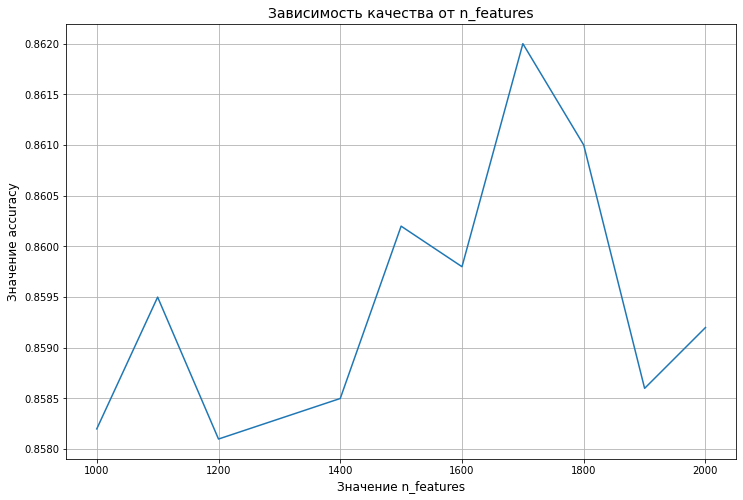

In [14]:
plt.figure(figsize = (12, 8))
plt.xlabel('Значение n_features', fontsize = 12)
plt.ylabel('Значение accuracy', fontsize = 12)
plt.title('Зависимость качества от n_features', fontsize = 14)
plt.plot(features_grid, acc_history)
plt.grid()
;

Из графика видно, что качество колеблется в каком-то маленьком промежутке и несильно меняется в зависимости от числа новых признаков. Однако и какого-то явного плато тоже нельзя заметить, возможно оно найдется где-то справа при более высоких значениях n_features. В целом можно сказать, что качество несильно зависит от числа новых признаков

3) Сравниваем логрег и SVM:

In [15]:
pipeline_svc = RFFPipeline(n_features=1000, new_dim=50, feature_creator_class=RandomFeatureCreator,
                      classifier_class=SVC, classifier_params = {'kernel': 'linear', 'max_iter': 10**4})
pipeline_svc.fit(x_train, y_train)
pred_svc = pipeline_svc.predict(x_test)
acc_svc = (pred_svc == y_test).mean()
print(f'Accuracy для RFF c SVM: {acc_svc}')

Accuracy для RFF c SVM: 0.7995


RFF с SVM в качестве классификатора обучается прям сильно дольше, а качество показывает поменьше. Так что, да, важно, какую модель обучать, и в данной задаче логрег показывает себя лучше (и по времени, и по качеству)

__Задание 4. (Максимум 1.5 балла)__

Как вы, должно быть, помните с курса МО-1, многие алгоритмы машинного обучения работают лучше, если признаки данных некоррелированы. Оказывается, что для RFF существует модификация, позволяющая получать ортогональные случайные признаки (Orthogonal Random Features, ORF). Об этом методе можно прочитать в [статье](https://proceedings.neurips.cc/paper/2016/file/53adaf494dc89ef7196d73636eb2451b-Paper.pdf). Реализуйте класс для вычисления ORF по аналогии с основным заданием. Обратите внимание, что ваш класс должен уметь работать со случаем n_features > new_dim (в статье есть замечание на этот счет), n_features=new_dim и n_features < new_dim также должны работать, убедитесь в этом. Проведите эксперименты, сравнивающие RFF и ORF, сделайте выводы. 


При написании класса пользовался GPT, чтобы повысить качество, так как изначально оно было не очень. Промптом была моя реализация по шаблону + условие задания + информация из статьи. В итоге я понял, как правильно обработать случай D > d (создать массив из матриц а потом сделать vstack), нашел функцию np.linalg.qr. И самое главное, GPT подсказал, что нужно брать корень из Хи-квадрат распределения и качество выросло с 0.65 до 0.8+ (интересно, почему про это не говорилось в статье?)

In [17]:
from homework_practice_08_rff import OrthogonalRandomFeatureCreator

In [18]:
pipeline_ORF = RFFPipeline(n_features=1000, new_dim=50, feature_creator_class=OrthogonalRandomFeatureCreator)
pipeline_ORF.fit(x_train, y_train)
pred_ORF = pipeline_ORF.predict(x_test)
acc_ORF = (pred_ORF == y_test).mean()
print(f'Accuracy для ORF: {acc_ORF}')

Accuracy для ORF: 0.8589


Тут видно, что ORF в случае D>d работает прям самую малость хуже RFF (там было 0.8593), вряд ли это значимая разница. То есть метод вроде как тоже рабочий. Убедимся, что код работает и для других случаев. Сначала D<d:

In [19]:
pipeline_less = RFFPipeline(n_features=100, new_dim=500, feature_creator_class=OrthogonalRandomFeatureCreator)
pipeline_less.fit(x_train, y_train)
pred_less = pipeline_less.predict(x_test)
acc_less = (pred_less == y_test).mean()
print(f'Accuracy для ORF (случай D<d): {acc_less}')

Accuracy для ORF (случай D<d): 0.803


In [20]:
pipeline_less_RFF = RFFPipeline(n_features=100, new_dim=500, feature_creator_class=RandomFeatureCreator)
pipeline_less_RFF.fit(x_train, y_train)
pred_less_RFF = pipeline_less_RFF.predict(x_test)
acc_less_RFF = (pred_less_RFF == y_test).mean()
print(f'Accuracy для RFF (случай D<d): {acc_less_RFF}')

Accuracy для RFF (случай D<d): 0.8156


Для этого случая RFF также лучше. Теперь D = d:

In [21]:
pipeline_equal = RFFPipeline(n_features=500, new_dim=500, feature_creator_class=OrthogonalRandomFeatureCreator)
pipeline_equal.fit(x_train, y_train)
pred_equal = pipeline_equal.predict(x_test)
acc_equal = (pred_equal == y_test).mean()
print(f'Accuracy для ORF (случай D=d): {acc_equal}')

Accuracy для ORF (случай D=d): 0.8534


In [22]:
pipeline_equal_RFF = RFFPipeline(n_features=500, new_dim=500, feature_creator_class=RandomFeatureCreator)
pipeline_equal_RFF.fit(x_train, y_train)
pred_equal_RFF = pipeline_equal_RFF.predict(x_test)
acc_equal_RFF = (pred_equal_RFF == y_test).mean()
print(f'Accuracy для RFF (случай D=d): {acc_equal_RFF}')

Accuracy для RFF (случай D=d): 0.8554


В общем методы работают практически одинаково, какого-то значимого улучшения от ORF в этой задаче нет

__Задание 5. (Максимум 1 балл)__

Существует большое количество работ, где идея RFF развивается, предлагаются её обобщения (которые, по сути, выливаются в другие преобразования признаков, не обязательно уже тригонометрические). Возьмите любую из таких работ, кратко опишите идею, имплементируйте её и сравните качество с ORF и RFF, которые вы запрограммировали выше.

Ссылки на статьи, где обсуждаются вариации RFF для разных ядер, можно найти в окрестности таблицы 1 в работе https://arxiv.org/pdf/1407.5599  

___ссылка на работу:___ https://proceedings.neurips.cc/paper_files/paper/2022/file/718a3c5cf135894db6e718725f52ef9a-Paper-Conference.pdf

___описание идеи:___ В общем среди представленных работ я, к сожалению, не нашел ничего адекватного, что я бы смог применить, поэтому я просто загуглил какие еще есть способы аппроксимировать Гауссово ядро, и нашел, что можно брать знак. Дальше уже искал статьи на эту тему и нашел эту. Но тут почему-то берется знак после косинуса. Когда я попробовал так, то качество было не очень (что-то типо 0.65). Когда я убрал косинус, а оставил просто знак, качество получилось уже сопоставимое с обычным RFF.

In [24]:
from homework_practice_08_rff import SignRFF, RandomLaplaceFeatureCreator

In [25]:
pipeline_sign = RFFPipeline(n_features=1000, new_dim=50, feature_creator_class=SignRFF)
pipeline_sign.fit(x_train, y_train)
pred_sign = pipeline_sign.predict(x_test)
acc_sign = (pred_sign == y_test).mean()
print(f'Accuracy для Sign RFF: {acc_sign}')

Accuracy для Sign RFF: 0.8317


Как мы видим, качество чуть похуже, чем для тригонометрической аппроксимации, но в целом тоже неплохо

Если же нужно взять прям из того, что предложили, то есть также эта [статья](https://vikas.sindhwani.org/RandomLaplace.pdf), где предлагают просто генерировать w не из нормального, а из лапласовского распределения. Все-таки я подумал, что задание именно про другую аппроксимацию, а не другое ядро, поэтому решил взять статью со знаком

In [26]:
pipeline_RLF = RFFPipeline(n_features=1000, new_dim=50, feature_creator_class=RandomLaplaceFeatureCreator)
pipeline_RLF.fit(x_train, y_train)
pred_RLF = pipeline_RLF.predict(x_test)
acc_RLF = (pred_RLF == y_test).mean()
print(f'Accuracy для RLF: {acc_RLF}')

Accuracy для RLF: 0.8697


Интересненько, здесь качество получше, чем для стандартного RFF (0.8593)

__Задание 6. (Максимум 2.5 балла)__

Реализуйте класс ядровой Ridge регрессии (Лекция 13, $\S 1.2$), для оптимизации используте градиентный спуск **[1 балл максимум]**, также добавьте возможность использовать аналитическую формулу **[1 балл максимум]**. Для градиентного спуска выпишите градиент ниже **[0.5 баллов максимум]**. 
Подумайте о том, как в формулах правильно учесть свободный коэффициент. 

Затем адаптируйте вашу реализацию RFF под задачу регрессии. Сравните вашу ядровую регрессию и RFF на синтетических данных.

Функция потерь: 
$$
Q(w) = \frac{1}{2} ||\Phi \Phi^T w - y||^2 + \frac{\lambda}{2} w^T \Phi \Phi^T w \rightarrow \min_w,
$$
где $\Phi \Phi^T = K$, $K = (k(x_i, x_j))_{i, j = 1}^{\ell}$.

Предсказание: 
$
y(x) = k(x)^T w,
$
где $k(x)$ — вектор функций ядра от пар объектов $(x, x_i)_{i=1}^{\ell}$.

___Выведите градиент:___ 

$$
dQ(w) = \frac{1}{2}(d((Kw-y)^T)(Kw-y) + (Kw-y)^Td(Kw-y)) + \frac{\lambda}{2}(d(w^T)Kw + w^Td(Kw))
$$

$$
dQ(w) = \frac{1}{2}((Kw-y)^TKdw + (Kw-y)^TKdw) + \frac{\lambda}{2}(w^TK^Tdw + w^TKdw)
$$

$$
dQ(w) = ((Kw-y)^TK + \frac{\lambda}{2}(w^TK^T + w^TK))dw
$$

$$
\nabla Q(w) = K^T(Kw-y) + \frac{\lambda}{2}(Kw+K^Tw)
$$

В силу симметричности $K$:

$$
\nabla Q(w) = K^T(Kw-y) + \lambda Kw
$$

Дальше приравниваем к нулю и получаем решение:

$$
K^T(Kw-y) + \lambda Kw = 0
$$

$$
w^* = (K+\lambda I)^{-1}y
$$

Вы можете изменять представленный шаблон в файле `homework_practice_08_kernel_regression.py` по своему усмотрению.

По сути, адаптировать ничего и не нужно, просто вместо логрега или SVM будем указывать линейную регрессию.

In [27]:
from homework_practice_08_kernel_regression import KernelRidgeRegression
from sklearn.linear_model import Ridge

In [28]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

X, y = make_regression(
    n_samples=625, n_features=500, n_informative=4, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Сначала смотрим на качество RFF:

In [29]:
pipeline = RFFPipeline(n_features=1000, new_dim=50, feature_creator_class=RandomFeatureCreator,
                      classifier_class=Ridge)
pipeline.fit(X_train, y_train)
pred_rff = pipeline.predict(X_test)
mae_rff = np.mean(np.abs((pred_rff - y_test)))
print(f'MAE для RFF: {mae_rff}')

MAE для RFF: 96.71087807194297


Теперь обучаем ядровую регрессию:

In [30]:
ridge = KernelRidgeRegression()
ridge.fit(X_train, y_train)
pred_ridge = ridge.predict(X_test)
mae_ridge = np.mean(np.abs((pred_ridge - y_test)))
print(f'MAE для ядровой регрессии: {mae_ridge}')

MAE для ядровой регрессии: 95.1168409613107


Аналитическое решение также работает:

In [31]:
ridge = KernelRidgeRegression()
ridge.fit_closed_form(X_train, y_train)
pred_ridge = ridge.predict(X_test)
mae_ridge = np.mean(np.abs((pred_ridge - y_test)))
print(f'MAE для ядровой регрессии: {mae_ridge}')

MAE для ядровой регрессии: 95.1168409613107


Как мы видим, ядровая регрессия показывает себя чуть получше. Кажется, что это закономерный результат, так как RFF пытается аппроксимировать гауссово ядро

По поводу константы: как я только не пробовал ее добавлять, но качество только ухудшалось. По сути нам надо добавить константный признак в матрицу $\Phi$, но мы этого сделать явно не можем, так как этой матрицы у нас нет. На матрице Грама это отразится так, что просто к каждому элементу добавится 1. Кажется, что это не особо сильно повлияет на решение, нет никакой информативности. Я также пробовал добавить константу отдельно, типо $Kw + c$, но опять качество только упало. В общем я решил просто ее не добавлять, даже так качество у ядровой регрессии лучше чем у RFF. К тому же, мы не знаем какое у нас признаковое пространство, может быть там есть и константный признак :)